In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba
import emcee
import corner
import gsfit
import time

Load grayscale image that we wish to recreate with Newton-Raphson fractal

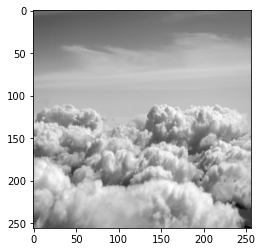

In [2]:
img = gsfit.image_processing('cloud_2.png')
plt.imshow(img, cmap='gray')

Now we wish to define properties of our fractal:
1. Set its resolution equal to that of image
2. Define appropriate limit for convergence for Newton-Raphson method
3. Make 2 arrays (out of laziness) for roots of polynomial
4. Boundary for points to be selected in evaluating $F_{dim}$

Furthermore, let's try creating a fractal with these properties

--- 0.8347682952880859 seconds ---


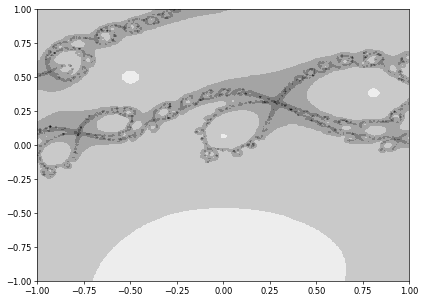

In [3]:
# array = np.array([-1 + 1.5*1j, 0-1j, 1+1.5*1j, 2-1j*2])
roots = np.array([
    [-1, 1.5],
    [0, -1], 
    [1, 1.5],
    [2, -2]])
array = []
for i in range(roots.shape[0]):
    array.append(roots[i][0] + 1j * roots[i][1])
array = np.array(array)
p = np.polynomial.Polynomial.fromroots(array)
resX, resY = img.shape[0], img.shape[1]
lim = 1e-6
boundary = 0.3

def make_fractal(array, roots, p, resX, resY, lim):
    
    Z = gsfit.grid_scaled(array, resX, resY)
    M, N = gsfit.assign_root(Z, lim, p, resX, resY, array, roots)
    N = N/np.max(N)
    # gsfit.plotFractal(Z, M)
    gsfit.plotFractal(Z, N, cmap='gray_r')
    # calculate_BoxDim(N, 0.05, 2, 20, 10, True, boundary=0.3)
    return Z, M, N


start_time = time.time()
Z, M, N = make_fractal(array, roots, p, resX, resY, lim)
print("--- %s seconds ---" % (time.time() - start_time))

Now we will need to make a few things for our emcee simulation
1. Create likelihood(?) function with values from $KS$ and diff($F_{dim}$)
2. Let our roots of complex polynomial roam and search for coordinates of roots in which $KS$ and diff($F_{dim}$). Aggregate of these values should reach closest to zero as possible.

In [5]:
def likelihood(positions, img, boundary):
    
    array = []
    for i in range(int(positions.shape[0]/2)):
        array.append(positions[2*i] + 1j * positions[2*i+1])
    array = np.array(array)
    
    roots = positions.reshape((int(positions.shape[0]/2), 2))
    
    p = np.polynomial.Polynomial.fromroots(array)
    resX, resY = img.shape[0], img.shape[1]
    lim = 1e-6
    
    Z = gsfit.grid_scaled(array, resX, resY)
    M, N = gsfit.assign_root(Z, lim, p, resX, resY, array, roots)
    
    fdim = gsfit.calculate_BoxDim(N, 0.05, 2, 20, 10, False, boundary)
    
    KS = gsfit.KS(img, N/np.max(N))
    
    return KS, fdim

def log_likelihood(positions, img, img_fdim, boundary):
    KS, fdim = likelihood(positions, img, boundary)
    
    KS = np.log10(np.max([0, 1-KS]))
    F = np.log10(np.max([0, 1-np.abs(fdim-img_fdim)]))
    
    return KS + F
    

def log_prior(positions):
    for p in positions:
        if p < -10 or p > 10:
            return -np.inf
    return 0
        

def log_probability(positions, img, img_fdim, boundary):
    lp = log_prior(positions)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(positions, img, img_fdim, boundary)

  5%|▍         | 119/2500 [13:37<2:30:01,  3.78s/it]D:\Temp\ipykernel_14472\1794053776.py:26: RuntimeWarning: divide by zero encountered in log10
  KS = np.log10(np.max([0, 1-KS]))
100%|██████████| 2500/2500 [3:15:56<00:00,  4.70s/it]  


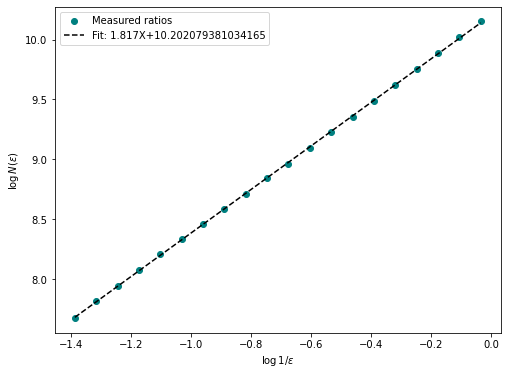

In [7]:
roots = np.array([
    [-1, 1.5],
    [0, -1], 
    [1, 1.5]])
roots = roots.reshape(roots.shape[0]*roots.shape[1])
# roots = roots.reshape((int(roots.shape[0]/2), 2))

ndim = roots.shape[0]

num_walkers = 12

pos = roots + np.random.normal(0, 1e-6, (num_walkers, ndim))

boundary = 0.8

img_fdim = gsfit.calculate_BoxDim(img, 0.05, 2, 20, 10, True, boundary)

sampler = emcee.EnsembleSampler(
    num_walkers, ndim, log_probability,
    args=(img, img_fdim, boundary)
)


sampler.run_mcmc(pos, 2500, progress=True);

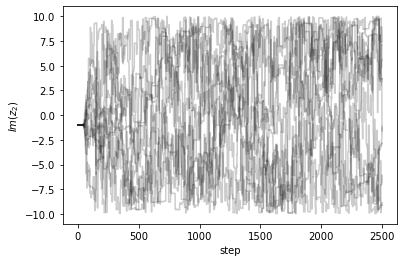

In [164]:
chain = sampler.get_chain()
chain.shape

for id_walker in range(0, chain.shape[1]):
    plt.plot(chain[:, id_walker, 3], label=id_walker, c='k', alpha=0.2)
plt.xlabel('step')
plt.ylabel(r'$Im(z_2)$')
# plt.xlim(0, 20)
# plt.ylim(1.99, 2.01)
# plt.legend()
plt.savefig('walkers_3roots.png')
plt.show()


(1992, 6)


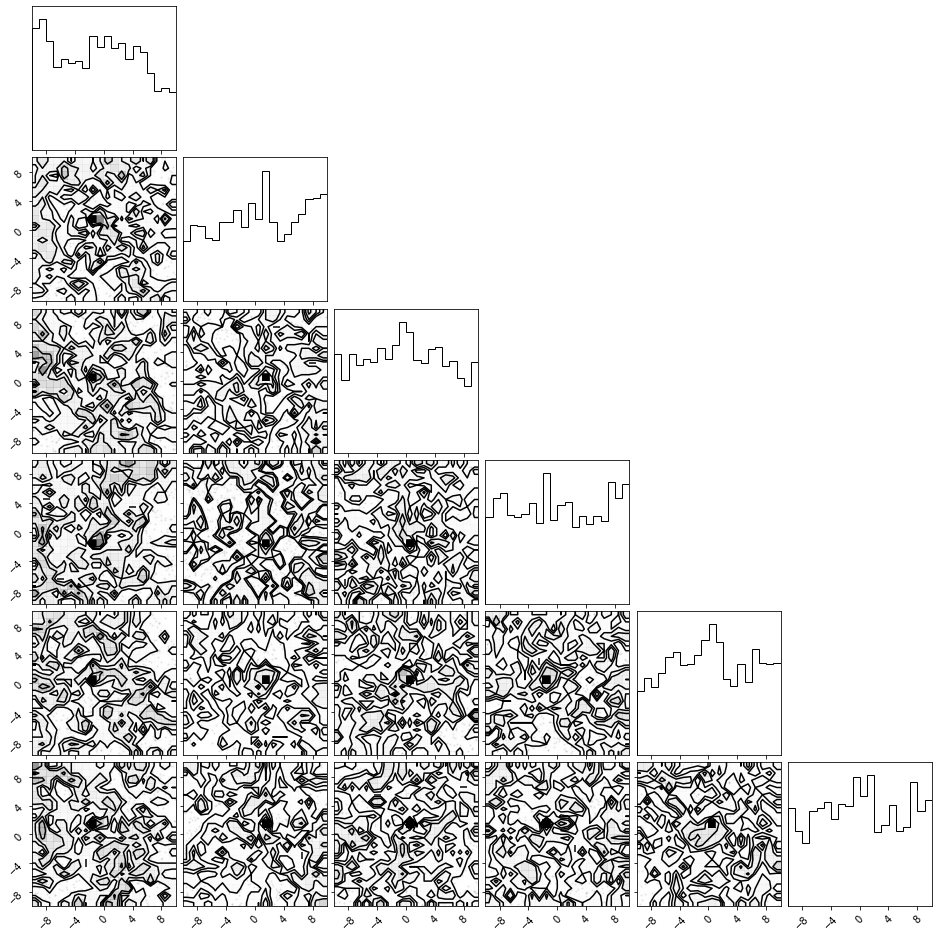

In [9]:
# import corner
flat_samples = sampler.get_chain(discard=0, thin=15, flat=True)
print(flat_samples.shape)
fig = corner.corner(
    flat_samples
);

In [15]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)
np.savetxt('3d-flat-samples.txt', flat_samples)
fig = corner.corner(
    flat_samples
);
plt.savefig('corner-3roots.png')

(1920, 6)


In [16]:
np.savetxt('3d-flat-samples.txt', flat_samples)

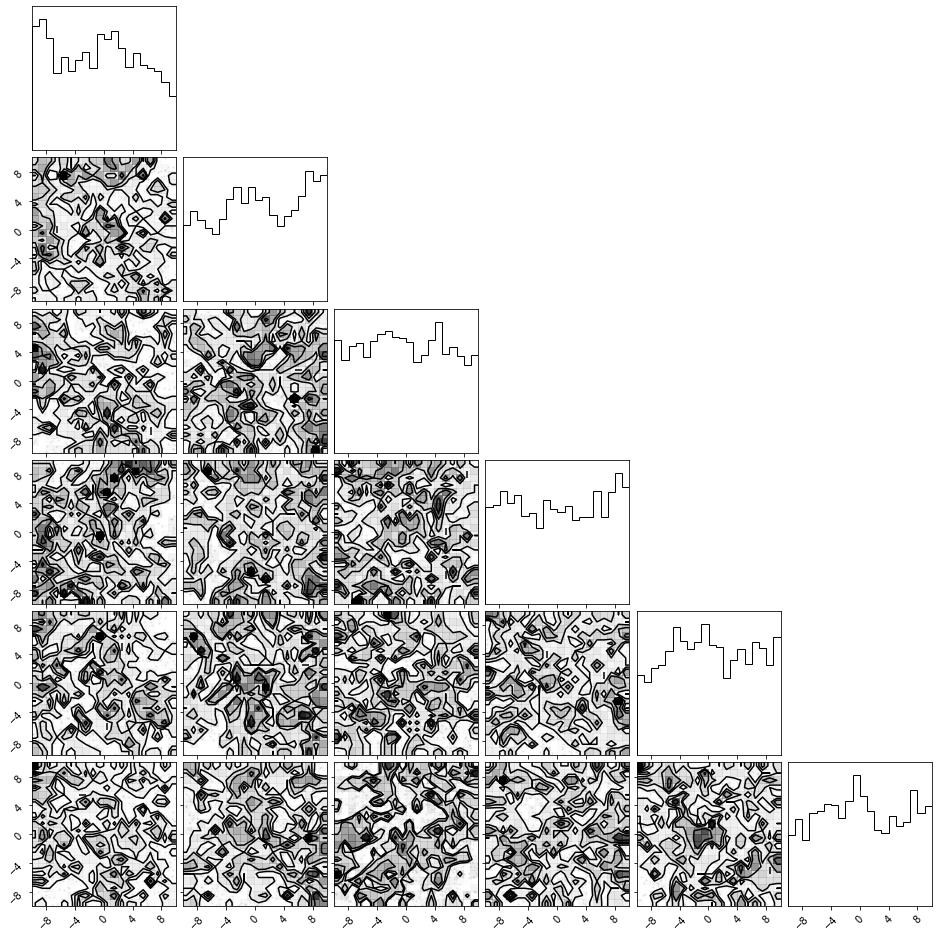

In [98]:
fig = corner.corner(
    flat_samples
);
plt.savefig('corner-3roots.png')

array([[-5.07948732,  7.28808737],
       [-6.21425533, -9.69225883],
       [ 5.13102102, -5.16896963]])

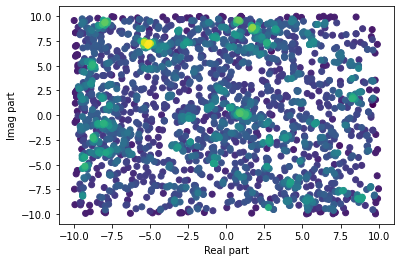

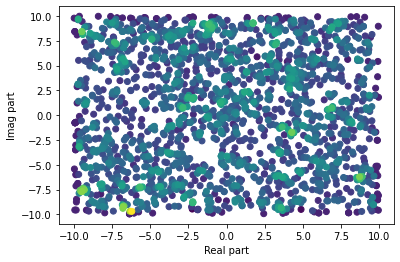

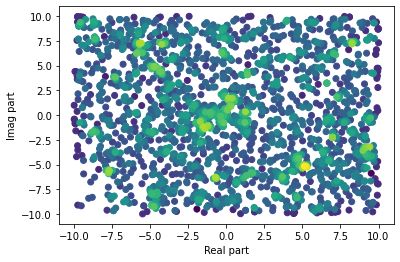

In [145]:
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn
def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )
    ax.set(xlabel='Real part', ylabel='Imag part')
    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    # cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
    # cbar.ax.set_ylabel('Density')

    return ax, x, y, z

roots_model = np.zeros(int(flat_samples.shape[1]/2), dtype=np.complex64)
# ax = None
for i in range(int(flat_samples.shape[1]/2)):
    ax, re, im, _ = density_scatter(flat_samples[:, 2*i], flat_samples[:, 2*i+1], bins=[40, 40])
    roots_model[i] = re[-1] + 1j * im[-1]
    plt.savefig('3roots_map'+str(i)+'.png')
    
roots = np.zeros(int(flat_samples.shape[1])).reshape(int(flat_samples.shape[1]/2), 2)
for i in range(roots.shape[0]):
    roots[i, :] = [roots_model[i].real, roots_model[i].imag]
roots

--- 0.3011956214904785 seconds ---
0.9931793212890625 0.13488943888912494


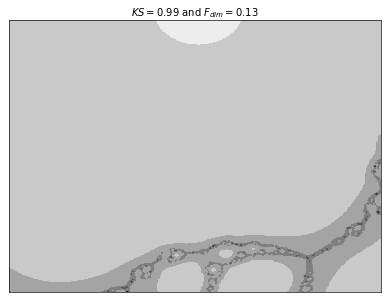

In [172]:
array = []
for i in range(roots.shape[0]):
    array.append(roots[i][0] + 1j * roots[i][1])
array = np.array(array)
p = np.polynomial.Polynomial.fromroots(array)
resX, resY = img.shape[0], img.shape[1]
lim = 1e-6
boundary = 0.3

def make_fractal(array, roots, p, resX, resY, lim):
    
    Z = gsfit.grid_scaled(array, resX, resY)
    M, N = gsfit.assign_root(Z, lim, p, resX, resY, array, roots)
    N = N/np.max(N)
    # gsfit.plotFractal(Z, M)
    gsfit.plotFractal(Z, N, cmap='gray_r')
    plt.xticks([]); plt.yticks([])
    f = gsfit.calculate_BoxDim(N, 0.05, 2, 20, 10, False, boundary=0.8)
    KS = gsfit.KS(img, N)
    plt.title(r'$KS=%1.2f$' %KS + r' and $F_{dim}=%1.2f$' %f)
    plt.savefig('end_fractal_3roots.png')
    return f, KS

start_time = time.time()
f, KS = make_fractal(array, roots, p, resX, resY, lim)
print("--- %s seconds ---" % (time.time() - start_time))
print(KS, f)

0.9842071533203125

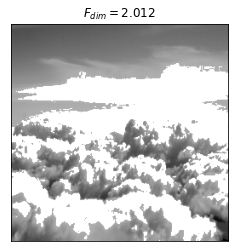

In [168]:
img1 = img
img1[img1 > 0.8] = 1
plt.imshow(img, cmap='gray')
plt.xticks([]); plt.yticks([])
plt.title(r'$F_{dim}=2.012$')
plt.savefig('cloud_boundary.png')

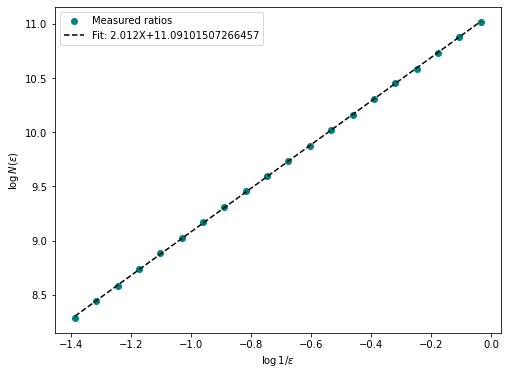

In [165]:
img_fdim = gsfit.calculate_BoxDim(img, 0.05, 2, 20, 10, True, boundary)

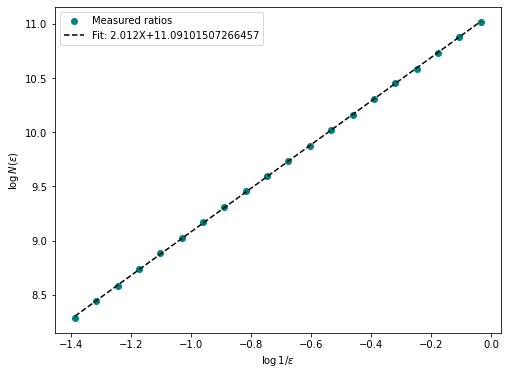

In [167]:
_ = gsfit.calculate_BoxDim(img1, 0.05, 2, 20, 10, True, boundary)